# Feature Engineering

Author : [Alexandre Gramfort](http://alexandre.gramfort.net)
         
         
with some code snippets from [Olivier Grisel](http://ogrisel.com/) (leaf encoder)

It is the most creative aspect of Data Science!

We will use here the Titanic dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
df = sns.load_dataset("titanic")

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Let's look at the dtypes of the different columns. You will observe that it contains columns that
are explicitly marked as `category`.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


This allows you to do things like:

In [5]:
from sklearn.compose import make_column_selector
make_column_selector(dtype_include='category')(df)

['class', 'deck']

in order to get quickly the names of the columns to treat as categorical.

As you can see the data contains both quantitative and categorical variables. These categorical have some predictive power:

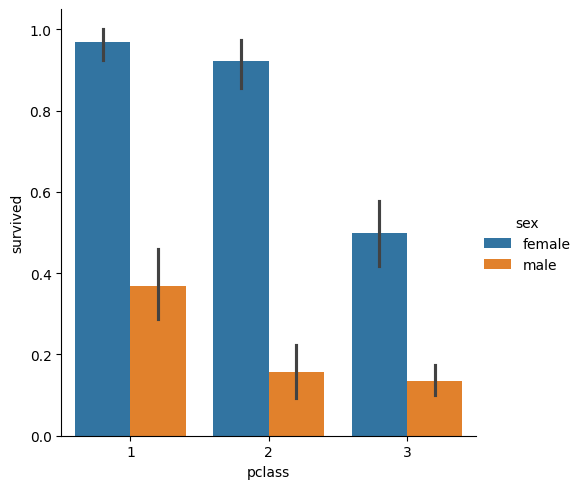

In [6]:
sns.catplot(data=df, x='pclass', y='survived', hue='sex', kind='bar')

The question is how to feed these non-quantitative features to a supervised learning model?

## Categorical features

 - Nearly always need some treatment
 - High cardinality can create very sparse data
 - Difficult to impute missing

### One-Hot encoding

**Idea:** Each category is coded as a 0 or 1 in a dedicated column.

 - It is the most basic method. It is used with most linear algorithms
 - Drop first column to avoid collinearity
 - It uses sparse format which is memory-friendly
 - Most current implementations don’t gracefully treat missing, unseen variables

Example with the `embarked` column. We have here 3 categories:

In [7]:
df['embarked'].value_counts()

embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [8]:
df1 = df[['embarked']]

In [9]:
df1.head(10)

,embarked
0,S
1,C
2,S
3,S
4,S
5,Q
6,S
7,S
8,S
9,C


Let's use a [scikit-learn OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [10]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit_transform(df1.head(10)).toarray()

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

To know which column corresponds to what you can look at:

In [11]:
ohe.categories_

[array(['C', 'Q', 'S'], dtype=object)]

Basically the first column will be a 1 if category was 'C', etc.

Now if we have missing values:

In [12]:
ohe = OneHotEncoder()
ohe.fit_transform(df1).toarray()

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

We have now 4 columns, one corresponding to NaNs:

In [13]:
ohe.categories_

[array(['C', 'Q', 'S', nan], dtype=object)]

As the columns are linearly dependant after one-hot encoding you can drop one column with:

In [14]:
OneHotEncoder(drop='first').fit_transform(df1.head(10)).toarray()

array([[0., 1.],
       [0., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 0.]])

This avoids colinearity, which for example leads to slower optimization solvers.

# Ordinal encoding

**Idea:** Each category is coded with a different integer. The order being arbitrary.

 - Give every categorical variable a unique numerical ID
 - Useful for non-linear tree-based algorithms (forests, gradient-boosting)
 - Does not increase dimensionality

In [15]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit_transform(df1.head(10))

array([[2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [0.]])

In [16]:
oe.categories_

[array(['C', 'Q', 'S'], dtype=object)]

This means that 'C' will be coded as 0, 'Q' as a 1 and 'S' as a 2.

## Count encoding

**Idea:** Replace categorical variables with their count in the train set

- Useful for both linear and non-linear algorithms
- Can be sensitive to outliers
- May add log-transform, works well with counts
- Replace unseen variables with `1`
- May give collisions: same encoding, different variables

You'll need to install the `category_encoders` package with:

    pip install category_encoders

In [17]:
import category_encoders as ce

In [18]:
ce.__version__

'2.6.3'

In [19]:
df1.head(10)

,embarked
0,S
1,C
2,S
3,S
4,S
5,Q
6,S
7,S
8,S
9,C


In [20]:
ce.CountEncoder().fit_transform(df1.head(10)).values

array([[7],
       [2],
       [7],
       [7],
       [7],
       [1],
       [7],
       [7],
       [7],
       [2]], dtype=int64)

'S' is replaced by 7 as it appears 7 times in the fitted data, etc.

## Label / Ordinal count encoding

**Idea:** Rank categorical variables by count and use this rank as encoding value. It is an ordinal encoding where the value is taking from the frequence of each category.

- Useful for both linear and non-linear algorithms
- Not sensitive to outliers
- Won’t give same encoding to different variables
- Best of both worlds

As it is not available in any package we will implement this ourselves:

In [21]:
from sklearn.preprocessing import OrdinalEncoder

class CountOrdinalEncoder(OrdinalEncoder):
    """Encode categorical features as an integer array
    usint count information.
    """
    def __init__(self, categories='auto', dtype=np.float64):
        self.categories = categories
        self.dtype = dtype

    def fit(self, X, y=None):
        """Fit the OrdinalEncoder to X.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.

        Returns
        -------
        self
        """
        self.handle_unknown = 'use_encoded_value'
        self.unknown_value = np.nan
        super().fit(X)
        X_list, _, _ = self._check_X(X)
        # now we'll reorder by counts
        for k, cat in enumerate(self.categories_):
            counts = []
            for c in cat:
                counts.append(np.sum(X_list[k] == c))
            order = np.argsort(counts)
            self.categories_[k] = cat[order]
        return self

coe = CountOrdinalEncoder()
coe.fit_transform(pd.DataFrame(df1.head(10)))

array([[2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [1.]])

'S' is replace by 2 as it's the most frequent, then 'C' is 1 and 'Q' is 0.

This encoding is robust to collision which can happen with the CountEncoder when certain categories happen the same number of times. Example:

In [22]:
coe.fit_transform(pd.DataFrame(['es', 'fr', 'fr', 'en', 'en', 'es']))

array([[1.],
       [2.],
       [2.],
       [0.],
       [0.],
       [1.]])

vs.

In [23]:
ce.CountEncoder().fit_transform(pd.DataFrame(['es', 'fr', 'fr', 'en', 'en', 'es']))

,0
0,2
1,2
2,2
3,2
4,2
5,2


# Hash encoding

**Idea:** Does “OneHot-encoding” with arrays of a fixed length.

- Avoids extremely sparse data
- May introduce collisions
- Can repeat with different hash functions and bag result for small bump in accuracy
- Collisions usually degrade results, but may improve it.
- Gracefully deals with new variables (eg: new user-agents)

In [24]:
df1.head(10)

,embarked
0,S
1,C
2,S
3,S
4,S
5,Q
6,S
7,S
8,S
9,C


In [25]:
ce.hashing.HashingEncoder(n_components=4).fit_transform(df1.head(10).values)

,col_0,col_1,col_2,col_3
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
5,0,0,1,0
6,0,0,1,0
7,0,0,1,0
8,0,0,1,0
9,0,0,0,1


## Target encoding

Encode categorical variables by their ratio of target (binary classification or regression)

Formula reads:

$$
    TE(X) = \alpha(n(X)) E[ y | x=X ] +  (1 - \alpha(n(X))) E[y]
$$

where $n(X)$ is the count of category $X$ and $\alpha$ is a monotonically increasing function bounded between 0 and 1.[1].

- Add smoothing to avoid setting variable encodings to 0.
```
[1] Micci-Barreca, 2001: A preprocessing scheme for
high-cardinality categorical attributes in classification
and prediction problems.
```

You will need the [dirty cat](https://pypi.org/project/dirty-cat/) package. You can install it with:

    pip install dirty_cat

In [26]:
import dirty_cat as dc  # install with: pip install dirty_cat

X = np.array(['A', 'B', 'C', 'A', 'B', 'B'])[:, np.newaxis]
y = np.array([1  , 1  , 1  , 0  , 0  , 1])

dc.TargetEncoder(clf_type='binary-clf').fit_transform(X, y)
# If \alpha was 1 you would get: [0.5, 0.66, 1, 0.5, 0.66, 0.66]

array([[0.58333333],
       [0.66666667],
       [0.77777778],
       [0.58333333],
       [0.66666667],
       [0.66666667]])

## NaN encoding

It is quite frequent in real life that the fact one variable is missing
has some predictive power. For example in the Titanic dataset the 'deck'
parameter is very often missing and it is missing often for passengers who
did not have a proper cabin and there who were most likely to die.

To inform your supervised model you can explicit encode the missingness
with a dedicated column.

You can do this with a [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

In [27]:
from sklearn.impute import SimpleImputer

X = np.array([0, 1., np.nan, 2., 0.])[:, None]
SimpleImputer(strategy='median', add_indicator=True).fit_transform(X)

array([[0. , 0. ],
       [1. , 0. ],
       [0.5, 1. ],
       [2. , 0. ],
       [0. , 0. ]])

or [MissingIndicator](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html)

In [28]:
from sklearn.impute import MissingIndicator

X = np.array([0, 1., np.nan, 2., 0.])[:, None]
MissingIndicator().fit_transform(X)

array([[False],
       [False],
       [ True],
       [False],
       [False]])

## Polynomial encoding

**Idea:** Encode interactions between categorical variables

- Linear algorithms without interactions can not solve the XOR problem
- A polynomial kernel *can* solve XOR

In [29]:
X = np.array([[0, 1], [1, 1], [1, 0], [0, 0]])
X

array([[0, 1],
       [1, 1],
       [1, 0],
       [0, 0]])

In [30]:
from sklearn.preprocessing import PolynomialFeatures
PolynomialFeatures(include_bias=False, interaction_only=True).fit_transform(X)

array([[0., 1., 0.],
       [1., 1., 1.],
       [1., 0., 0.],
       [0., 0., 0.]])

## To go beyond

You can also use some form of embedding eg using a Neural Network to create dense embeddings from categorical variables.

- Map categorical variables in a function approximation problem into Euclidean spaces
- Faster model training.
- Less memory overhead.
- Can give better accuracy than 1-hot encoded.
- See for example https://arxiv.org/abs/1604.06737

# Binning

See https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization_classification.html

[KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) allows you to estimate non-linear model in the original feature space while only using a linear logistic regression. 

See this [example in regression](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html).

What it does:

In [31]:
from sklearn.preprocessing import KBinsDiscretizer

rng = np.random.RandomState(42)
X = rng.randn(10, 2)
X

array([[ 0.49671415, -0.1382643 ],
       [ 0.64768854,  1.52302986],
       [-0.23415337, -0.23413696],
       [ 1.57921282,  0.76743473],
       [-0.46947439,  0.54256004],
       [-0.46341769, -0.46572975],
       [ 0.24196227, -1.91328024],
       [-1.72491783, -0.56228753],
       [-1.01283112,  0.31424733],
       [-0.90802408, -1.4123037 ]])

In [32]:
KBinsDiscretizer(n_bins=2).fit_transform(X).toarray()

array([[0., 1., 0., 1.],
       [0., 1., 0., 1.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [0., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.]])

# Scaling


Scale to numerical variables into a certain range

- Standard (Z) Scaling
- MinMax Scaling
- Root scaling
- Log scaling

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

rng = np.random.RandomState(42)
X = 10 + rng.randn(10, 1)
X

array([[10.49671415],
       [ 9.8617357 ],
       [10.64768854],
       [11.52302986],
       [ 9.76584663],
       [ 9.76586304],
       [11.57921282],
       [10.76743473],
       [ 9.53052561],
       [10.54256004]])

In [34]:
StandardScaler().fit_transform(X)

array([[ 0.07093253],
       [-0.85481899],
       [ 0.29104199],
       [ 1.56722474],
       [-0.99461815],
       [-0.99459421],
       [ 1.64913533],
       [ 0.46562306],
       [-1.33769874],
       [ 0.13777244]])

In [35]:
MinMaxScaler().fit_transform(X)

array([[0.4716135 ],
       [0.16166943],
       [0.54530673],
       [0.97257612],
       [0.1148643 ],
       [0.11487231],
       [1.        ],
       [0.60375694],
       [0.        ],
       [0.49399168]])

In [36]:
from sklearn.preprocessing import FunctionTransformer

X = np.arange(1, 10)[:, np.newaxis]
FunctionTransformer(func=np.log).fit_transform(X)

array([[0.        ],
       [0.69314718],
       [1.09861229],
       [1.38629436],
       [1.60943791],
       [1.79175947],
       [1.94591015],
       [2.07944154],
       [2.19722458]])

# Leaf coding

The following is an implementation of a trick found in:

Practical Lessons from Predicting Clicks on Ads at Facebook
Junfeng Pan, He Xinran, Ou Jin, Tianbing XU, Bo Liu, Tao Xu, Yanxin Shi, Antoine Atallah, Ralf Herbrich, Stuart Bowers, Joaquin Quiñonero Candela
International Workshop on Data Mining for Online Advertising (ADKDD)

https://research.fb.com/wp-content/uploads/2016/11/practical-lessons-from-predicting-clicks-on-ads-at-facebook.pdf

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import hstack


class TreeTransform(BaseEstimator, TransformerMixin):
    """One-hot encode samples with an ensemble of trees
    
    This transformer first fits an ensemble of trees (e.g. gradient
    boosted trees or a random forest) on the training set.

    Then each leaf of each tree in the ensembles is assigned a fixed
    arbitrary feature index in a new feature space. If you have 100
    trees in the ensemble and 2**3 leafs per tree, the new feature
    space has 100 * 2**3 == 800 dimensions.
    
    Each sample of the training set go through the decisions of each tree
    of the ensemble and ends up in one leaf per tree. The sample if encoded
    by setting features with those leafs to 1 and letting the other feature
    values to 0.
    
    The resulting transformer learn a supervised, sparse, high-dimensional
    categorical embedding of the data.
    
    This transformer is typically meant to be pipelined with a linear model
    such as logistic regression, linear support vector machines or
    elastic net regression.
    """
    def __init__(self, estimator):
        self.estimator = estimator
        
    def fit(self, X, y):
        self.fit_transform(X, y)
        return self
        
    def fit_transform(self, X, y):
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y)
        self.binarizers_ = []
        sparse_applications = []
        estimators = np.asarray(self.estimator_.estimators_).ravel()
        for t in estimators:
            lb = LabelBinarizer(sparse_output=True)
            X_leafs = t.tree_.apply(X.astype(np.float32))
            sparse_applications.append(lb.fit_transform(X_leafs))
            self.binarizers_.append(lb)
        return hstack(sparse_applications)
        
    def transform(self, X, y=None):
        sparse_applications = []
        estimators = np.asarray(self.estimator_.estimators_).ravel()
        for t, lb in zip(estimators, self.binarizers_):
            X_leafs = t.tree_.apply(X.astype(np.float32))
            sparse_applications.append(lb.transform(X_leafs))
        return hstack(sparse_applications)


boosted_trees = GradientBoostingClassifier(
    max_leaf_nodes=5, learning_rate=0.1,
    n_estimators=10, random_state=0,
)

from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)

TreeTransform(boosted_trees).fit_transform(X, y)

<150x146 sparse matrix of type '<class 'numpy.int32'>'
	with 4450 stored elements in Compressed Sparse Row format>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>
      Limiting yourself to LogisticRegression propose features to predict survival.
      </li>
    </ul>
</div>

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

y = df.survived.values
X = df.drop(['survived', 'alive'], axis=1)

In [39]:
X.head()

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [40]:
lr = LogisticRegression(solver='lbfgs')
ct = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), ['age', 'pclass', 'fare'])
)
clf = make_pipeline(ct, lr)
np.mean(cross_val_score(clf, X, y, cv=10))

0.7026591760299625

### Now do better !